In [19]:
from __future__ import absolute_import, division, print_function, unicode_literals


try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras import layers,Model
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

Train set shape: (60000, 28, 28, 1)
Test set shape: (10000, 28, 28, 1)
Train categorical labels shape: (60000, 10)
Test categorical labels shape: (10000, 10)
2 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


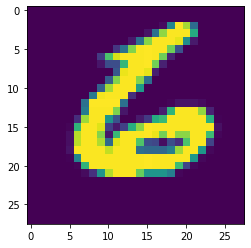

In [33]:

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train= x_train/127.5 -1
y_train= y_train/127.5 -1
# Add one dimmention for the grayscale channel
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Labels to categorical (one hot)
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)
# Display dataset info
print ('Train set shape:', x_train.shape)
print ('Test set shape:', x_test.shape)
print ('Train categorical labels shape:', y_train_cat.shape)
print ('Test categorical labels shape:', y_test_cat.shape)
# Show one example
2
print (y_test[1], y_test_cat[1])
plt.imshow(x_test[9999,:,:,0])

In [34]:
# Discriminator using DNN
D = Sequential(name='Discriminator')
# Layer 1
D.add(Flatten(input_shape=(28, 28, 1)))
D.add(Dense(1024))
3
D.add(BatchNormalization())
D.add(Activation('relu'))
# Layer 2
D.add(Dense(10))
D.add(Activation('softmax'))
D.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001, 0.5), metrics=['accuracy'])
D.summary()
D.fit(x_train, y_train_cat, validation_data=(x_test, y_test_cat))

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              803840    
_________________________________________________________________
batch_normalization_5 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_17 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                10250     
_________________________________________________________________
activation_18 (Activation)   (None, 10)                0         
Total params: 818,186
Trainable params: 816,138
Non-trainable params: 2,048
___________________________________________

In [36]:
# Discriminator using CNN
D = Sequential(name='Discriminator')
# Layer 1
D.add(Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
D.add(Activation('relu'))
# Layer 2
D.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
D.add(Activation('relu'))
# Layer 3
D.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
D.add(Activation('relu'))
# Layer 4
D.add(Flatten())
D.add(Dense(128))
D.add(Activation('relu'))
# Layer 5
D.add(Dense(10))
D.add(Activation('softmax'))
D.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001, 0.5), metrics=['accuracy'])
D.summary()
D.fit(x_train, y_train_cat, validation_data=(x_test, y_test_cat))

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
activation_24 (Activation)   (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 64)          51264     
_________________________________________________________________
activation_25 (Activation)   (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 128)         204928    
_________________________________________________________________
activation_26 (Activation)   (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2048)            

In [27]:
D_noise=100 #taille du vecteur de bruit gaussien

G= Sequential()
G.add(Dense(256,input_shape=(100,) ))
G.add(BatchNormalization() )
G.add(Activation('relu'))
#add more layers here
G.add(Reshape((28,28,1)))

In [28]:
D.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, 0.5))
D.trainable = False
gan_input = Input(shape=(100,))
gan_output = D(G(gan_input))
gan = Model(gan_input, gan_output) # This is the combined model
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, 0.5))
gan.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 28, 28, 1)         26880     
_________________________________________________________________
Discriminator (Sequential)   (None, 10)                520586    
Total params: 547,466
Trainable params: 26,368
Non-trainable params: 521,098
_________________________________________________________________


In [39]:
batch_size = 64
x_train_c = x_train[np.where(y_train == 4)[0]] # Lets train only for numbers 4
num_batches = int(len(x_train_c) / batch_size)
for epoch in range(20):
    for batch in range(num_batches):
        # Select a random batch from x_train_c
        x = x_train_c[np.random.randint(0, len(x_train_c), size=batch_size)]
        # Gaussian noise for the generator model
        noise = np.random.normal(0, 1, size=[batch_size, 100])
        # Generate fake images
        gen_imgs = G.predict(noise)
        disc_data = np.concatenate([x, gen_imgs])
        # True images are labeled 1, false ones are 0
        labels = [0.9]*batch_size + [0]*batch_size
        D.trainable = True
        dloss = D.train_on_batch(disc_data, labels)
        D.trainable = False # Freeze the discriminator
        gloss = gan.train_on_batch(noise, [1]*batch_size)
        print ('\b'*79 + '\r', end='')
        print ('Epoch %d, batch %d/%d: ' % (epoch+1, batch, num_batches) + ' gloss=%.4f, dloss=%.4f' % (gloss, dloss), end='')
    print ('')
# Save the weights after training
G.save_weights('./gen_weights.hdf5')
D.save_weights('./disc_weights.hdf5')

In [46]:
noise = np.random.normal(0, 1, size=[4, 100])
print(noise)
gen_imgs = G.predict(noise)
for i in range(len(noise)):
    plt.imshow((gen_imgs[i] + 1) / 2)
    plt.show()
    plt.imsave('img%02d.png' % i, gen_imgs[i])

[[-1.31980929e+00  8.00345540e-01  5.64266276e-01  2.18865689e-01
   1.55962424e+00  8.65688831e-01 -2.98139455e+00  1.07058608e+00
  -4.59096046e-01 -1.51853120e+00 -1.99593912e+00 -1.01738144e+00
  -2.90465650e-01  5.62735510e-01 -4.97763398e-02  1.44678660e-01
  -1.49704183e+00  1.50826992e-01  3.66634515e-02 -1.14769511e-01
   8.67776923e-01  1.92358142e-01 -1.35606102e+00 -2.16261296e+00
  -2.93073016e-01 -2.04520110e+00 -1.85520613e+00  4.81096568e-01
  -4.87085964e-01 -5.57275748e-01  2.72589399e+00  4.54678133e-01
  -1.82683235e+00  5.44526607e-01 -2.29443245e+00  4.36131302e-01
   2.18105331e-01 -7.07051063e-01  1.69667296e+00 -9.69078949e-02
  -1.09780104e+00  5.62098114e-01  2.50288166e-01  7.19797707e-01
  -4.77100954e-01  1.83668581e+00  8.28656959e-01 -1.28767152e+00
   4.20910415e-01  5.46724043e-01 -1.26519000e+00 -5.26115161e-01
   4.10045218e-01  1.50093354e+00  7.78848675e-01 -1.67713508e+00
  -6.07898243e-01 -3.89366508e-01 -1.07379924e+00  2.98014745e-01
  -1.31930

InvalidArgumentError:  Input to reshape is a tensor with 1024 values, but the requested shape has 3136
	 [[node sequential_3/reshape_1/Reshape (defined at <ipython-input-30-4650c0834010>:2) ]] [Op:__inference_distributed_function_24412]

Function call stack:
distributed_function
